# Mod 3 Project: Movie Database Analysis

## The data
The data we are using has come from The Movie Database (https://www.themoviedb.org/) and includes information on budget and user ratings.

### Hypotheses:

1. H0: There is no correlation between user rating and budget for top rated movies made in 2018.

   H1: There is a correlation between user rating and budget for top rated movies made in 2018.
   

2. H0: There is no significant difference in user rating depending on the genre for top rated movies in 2018.

   H1: There is a significant difference in user rating depending on the genre for top rated movies in 2018.


3. H0: There is no significant difference in user rating between an original movie and its most recent remake.

   H1: There is a significant difference in user rating between an original movie and its most recent remake.

## Import necessary packages


In [554]:
from api import API
import requests
import time
from itertools import chain
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower, TTestPower
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib import rcParams as params

## API Calling 

To start, we are going to gather information about the top rated movies by users on The Movie Database. We have found that there are 792 pages, so we will iterate our API call through all of these pages. 

The call limit is 40 per minute, so we have used a sleep function to rest 2 seconds between each call. 

We are then appending all of these page calls to a list for easier access to our data.

In [157]:
pages = list(range(1, 793))
all_2018 = []
for page in pages:
    response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key={}&language=en-US&sort_by=vote_average.desc&include_adult=false&include_video=false&page={}&primary_release_year=2018'.format(API, page))
    time.sleep(2)
    if response.status_code == 200:
        all_2018.append(response.json()['results'])
    else: 
        print('unauthorized')

In order to better visualize our data for cleaning, we will unlist our data and put it into a pandas dataframe.

We will then do some cleaning to have a better and more clear idea of our data.

In [160]:
all_2018_unlist = list(chain.from_iterable(all_2018))

In [165]:
df_2018 = pd.DataFrame.from_records(all_2018_unlist)
print(len(df_2018)) #Print how many rows
print(df_2018.columns) #Print column names
df_2018.head()

15840
Index(['adult', 'backdrop_path', 'genre_ids', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'release_date', 'title', 'video', 'vote_average', 'vote_count'],
      dtype='object')


,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/5sTXzeEmRbZ66HJ3lj9uO5USgr7.jpg,"[80, 53]",413881,en,According to Matthew,A highly respected priest conspires with his m...,3.372,/yw1qLqwXQORZqNO5aRLZywYSPBr.jpg,2018-11-24,According to Matthew,False,10.0,5
1,False,None,"[10402, 99]",571679,en,Now United: Dreams Come True,See how the group came to be and what it took ...,0.600,/hINGeQe5psODwFzkHIOg0HqmYZa.jpg,2018-12-29,Now United: Dreams Come True,False,10.0,3
2,False,/gUg3rm2kbnMj2fA7yPQGJ4rap6P.jpg,"[16, 12]",561974,ko,점박이 한반도의 공룡 2: 새로운 낙원,"Speckles, a ferocious tarbosaurus and his youn...",5.845,/ybHM7tXJ96sXf86wAq5orGz1xET.jpg,2018-12-25,Dino King 3D: Journey to Fire Mountain,False,10.0,3
3,False,/7LD18Y2V7FtPSryQoio6jOKPPEy.jpg,"[18, 10402]",515264,en,Hall American: Forbidden,,0.749,/1K1477QWuZ86q8urc9IjJr4T7vo.jpg,2018-03-15,Hall American: Forbidden,False,10.0,3
4,False,None,[],496332,hi,KHATA-Kaash Humse Na Hoti,An upcoming crime movie starring Shahid Kapoor.,0.853,/hElu4XTHxbGT2JKMZtrUbvDCpAy.jpg,2018-08-14,KHATA-Kaash Humse Na Hoti,False,10.0,3


In [193]:
df = df_2018[['id', 'title', 'genre_ids', 'vote_average', 'vote_count', 'popularity']]

In [537]:
df.vote_count.replace(0, np.NaN, inplace = True)

In [201]:
df = df[df['vote_count'] >= 50]

After looking at our data we noticed that there was a good deal of movies that had very few reviews with a high rating. We decided to make our cutoff number of votes 50 to have a better idea of what users enjoyed.

It is important to note that our highest rated movie after increasing the vote count threshold to 50 was only 8.4.

In [228]:
mov_ids = list(df.id)

In [522]:
# mov_ids

Now we can use our movie IDs to pass in to our API call to retrieve budget details about these movies.

In [254]:
mov_ids = list(df.id)
ids = []
budget = []
for mov_id in mov_ids:
    response = requests.get('https://api.themoviedb.org/3/movie/{}?api_key={}&language=en-US'.format(mov_id, API))
    time.sleep(2)
    if response.status_code == 200:
        ids.append(response.json()['id'])
        budget.append(response.json()['budget'])
    else: 
        print('unauthorized')

In [332]:
budget_data = dict(zip(ids, budget))

In [333]:
df1 = pd.DataFrame.from_dict(budget_data, orient = 'index')

In [352]:
df1.columns = ['id','budget']

In [335]:
df1 = df1[df1.budget != 0]

In [336]:
df1 = df1.reset_index()

## Storing Budget Data in SQL

Now, let's create and connect to our database so we can store our data into SQL.

In [354]:
import sqlite3
conn = sqlite3.connect('tmdb.db')
c = conn.cursor()

In [440]:
c.execute('''CREATE TABLE IF NOT EXISTS budgets
                 ([index] INTEGER PRIMARY KEY,
                 [id] integer,
                 [budget] integer)''')

In [441]:
for i in range(0, len(df1)):
    try:
        c.execute('''INSERT INTO budgets 
            (id, budget)
            VALUES(?,?)''', 
            (int(df1['id'][i]),
            df1['budget'][i]))
        conn.commit()
    except:
        print(df1['id'][i], df1['budget'][i])
        

In [375]:
df.drop(['genre_ids'], axis = 1, inplace = True)

In [431]:
c.execute('''CREATE TABLE IF NOT EXISTS top_rated
                 ([index] INTEGER PRIMARY KEY,
                 [id] integer,
                 [title] text,
                 [vote_average] integer, 
                 [vote_count] integer, 
                 [popularity] integer
                 )''')

In [432]:
for i in range(0, len(df)):
    try:
        c.execute('''INSERT INTO top_rated 
            (id, title, vote_average, vote_count, popularity)
            VALUES(?,?,?,?,?)''', 
            (int(df['id'][i]),
            df['title'][i], 
            df['vote_average'][i],
            df['vote_count'][i],
            df['popularity'][i]))
        conn.commit()
    except:
        print(df['id'][i], df['title'][i], df['vote_average'][i], df['vote_count'][i], df['popularity'][i])

## Reading from SQL

Now we can import our stored data and turn them into pandas dataframes to run some stats more easily

In [45]:
import sqlite3
conn = sqlite3.connect('tmdb.db')
c = conn.cursor()

In [124]:
budgets_df = pd.read_sql('SELECT * FROM budgets', conn)

In [125]:
budgets_df['budget_c'] = budgets_df.budget.transform(lambda x: int.from_bytes(x, 'little'))

In [126]:
budgets_df.drop(['budget'], axis = 1, inplace = True)

In [99]:
# budgets_df

In [127]:
top_rated_df = pd.read_sql('SELECT * FROM top_rated', conn)

In [128]:
top_rated_df

,index,id,title,vote_average,vote_count,popularity
0,1,324857,Spider-Man: Into the Spider-Verse,8.4,4368,53.442
1,2,517814,Capernaum,8.4,361,14.307
2,3,489471,The Dawn Wall,8.4,73,7.006
3,4,529531,Hannah Gadsby: Nanette,8.4,115,6.086
4,5,423612,Never Look Away,8.4,90,12.388
5,6,490003,Won't You Be My Neighbor?,8.4,209,9.686
6,7,490132,Green Book,8.3,3733,32.594
7,8,299536,Avengers: Infinity War,8.3,14323,92.710
8,9,538362,On My Skin,8.2,1091,10.110
9,10,504253,I Want to Eat Your Pancreas,8.2,80,5.280


We can now merge our budgets information and movie details for analysis

In [129]:
df_merged = pd.merge(top_rated_df, budgets_df, on = 'id')

## More API Calls and SQL!

Now we want to get genre and remake information for our other analyses

In [150]:
url = 'https://api.themoviedb.org/3/genre/movie/list?api_key={}&language=en-US'.format(API)
response = requests.get(url)
genres = response.json()['genres']
genres_df = pd.DataFrame.from_records(genres)

In [159]:
c.execute("""CREATE TABLE IF NOT EXISTS genres
            ([index] INTEGER PRIMARY KEY,
            [id] integer,
            [genre] text)""")

In [163]:
for i in range(0, len(genres_df)):
    try:
        c.execute('''INSERT INTO genres 
            (id, genre)
            VALUES(?,?)''', 
            (int(genres_df['id'][i]),
            genres_df['name'][i]))
        conn.commit()
    except:
        print(genres_df['id'][i], genres_df['name'][i])

Here we are calling to store the genres associated with each top movie

In [180]:
updated_pages = list(range(1, 795))
extra_info = []
for page in updated_pages:
    response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key={}&language=en-US&sort_by=vote_average.desc&include_adult=false&include_video=false&page={}&primary_release_year=2018'.format(API, page))
    time.sleep(3)
    if response.status_code == 200:
        extra_info.append(response.json()['results'])
    else: 
        print('unauthorized')

We have set the same vote count parameters so that we end up with the same movies and applied some simple cleaning.

In [231]:
forgenre_unlist = list(chain.from_iterable(extra_info))
df_genre = pd.DataFrame.from_records(forgenre_unlist)
df_genre.vote_count.replace(0, np.NaN, inplace = True)
df_genre = df_genre[df_genre['vote_count'] >= 50]
df_genre = df_genre[['id', 'genre_ids', 'title']]
df_genre.reset_index(inplace = True)
df_genre.drop(['index'], axis = 1, inplace = True)

In [236]:
df_genre = df_genre[df_genre.genre_ids.map(lambda x: len(x) > 0)]

There are many movies that have an elaborate collection of genres - we have chosen the first listed genre as it is likely the broader theme of the movie.

In [527]:
df_genre['theme'] = df_genre.genre_ids.apply(lambda x: x[0])

In [528]:
df_genre.drop('genre_ids', axis = 1, inplace = True)

In [529]:
df_genre.theme = df_genre.theme.apply(lambda x: int(x))

In [288]:
df_genre.reset_index(inplace = True)

In [530]:
df_genre.drop(['level_0', 'index'], axis = 1, inplace = True)

Here we are creating and storing our genre info SQL table

In [293]:
c.execute("""CREATE TABLE IF NOT EXISTS genre_info
            ([index] INTEGER PRIMARY KEY,
            [id] integer,
            [genre_id] integer)""")

In [294]:
for i in range(0, len(df_genre)):
    try:
        c.execute('''INSERT INTO genre_info 
            (id, genre_id)
            VALUES(?,?)''', 
            (int(df_genre['id'][i]),
            int(df_genre['theme'][i])))
        conn.commit()
    except:
        print(df_genre['id'][i], df_genre['theme'][i])

In [541]:
genres = pd.read_sql('SELECT * FROM genres', conn)

In [542]:
genre_info = pd.read_sql('SELECT * FROM genre_info', conn)

In [543]:
genre_info.drop(['index'], axis = 1, inplace = True)

I'm cleaning and merging our information on genres so as to more easily access our data. I have set the count per genre as greater than 10 so that we can have an adequate number of samples for each genre. 

In [544]:
genre_merged = pd.merge(top_rated_df, genre_info, on = 'id')

In [546]:
genre_merged = pd.merge(genres, genre_merged, left_on = 'id', right_on = 'genre_id')

In [550]:
genre_merged = genre_merged.groupby('genre_id').filter(lambda x : len(x)>= 10)

In [552]:
genre_merged.head()

,index_x,id_x,genre,index_y,id_y,title,vote_average,vote_count,popularity,genre_id
0,1,28,Action,1,324857,Spider-Man: Into the Spider-Verse,8.4,4368,53.442,28
1,1,28,Action,64,260513,Incredibles 2,7.6,6538,36.410,28
2,1,28,Action,67,383498,Deadpool 2,7.5,8980,43.571,28
3,1,28,Action,72,503314,Dragon Ball Super: Broly,7.4,761,4.467,28
4,1,28,Action,82,284054,Black Panther,7.4,12640,49.144,28


### Remake information

This file contains remakes scraped from a USA Today article: 

https://www.usatoday.com/picture-gallery/life/entertainthis/2018/05/05/best-and-worst-movie-remakes-of-all-time/34498459/

(See Greg's notebook)

In [300]:
remakes = pd.read_csv('remakes.csv')

In [302]:
remakes.drop('Unnamed: 0', axis = 1, inplace = True)

In [306]:
remakes.drop_duplicates(inplace = True)

After cleaning the dataset, I have created a list that we can iterate through for our search API calls

In [326]:
remake_list = list(remakes['movie_names'])

In [327]:
remake_search = []
for remake in remake_list:
    response = requests.get('https://api.themoviedb.org/3/search/movie?api_key={}&language=en-US&query={}&page=1&include_adult=false'.format(API, remake))
    time.sleep(2)
    if response.status_code == 200:
        remake_search.append(response.json()['results'])
    else: 
        print('unauthorized')

In [330]:
remake_unlist = list(chain.from_iterable(remake_search))

In [336]:
remake_df = pd.DataFrame.from_records(remake_unlist)

After making a dataframe of our details for each movie remake, we now need to do some cleaning so that we are only using the original and the most recent remake. I have done this by first setting our initial vote count parameter and removing duplicate responses. Further, I have merged this list with the original list of remake titles as the search parameter returned similar titles. 

In [339]:
remake_df = remake_df[['id', 'title', 'release_date', 'vote_average', 'vote_count']]

In [348]:
remake_df = remake_df[remake_df['vote_count'] >= 50]

In [350]:
remake_df.reset_index(inplace = True)

In [531]:
remake_df.drop('index', axis = 1, inplace = True)

In [532]:
remake_df.drop_duplicates(inplace = True)

In [389]:
rm_df = pd.DataFrame(remake_list)
rm_df.columns = ['title']

In [391]:
merged_remake = pd.merge(remake_df, rm_df, on = 'title')

Below we have a list of movies that no longer had a pair or were an additional but not the most recent remake. I have dropped the movies within this list.

In [434]:
to_drop = [42884, 10772, 2020, 8198, 13188, 17979, 16716, 13189, 428081, 197796, 648, 1553, 16559, 43828, 6844, 63, 11673, 5528, 17809, 38985, 3111, 19610, 10445, 11113, 6404, 60935, 10714, 13528, 949, 58857, 34148, 1422, 4481, 8970, 36355, 13972, 25137, 97434, 87567, 5689, 10067, 13184, 46717, 14347, 24070, 263472, 929, 10484, 11045, 18681, 28696]

In [435]:
merged_remake = merged_remake[~merged_remake.id.isin(to_drop)]

I have now set up an identifier method to pair the movies up so that we can easily sort.

In [479]:
identifiers = []
for num in list(range(1, 56)):
    identifiers.append([num]*2)

identifiers = list(chain.from_iterable(identifiers))

In [533]:
merged_remake['identifiers'] = identifiers

By sorting through identifiers and release date, we have paired up our movies such that the first one listed is the original and the second is the most recent remake.

In [465]:
merged_remake = merged_remake.sort_values(by=['identifiers', 'release_date'])

In [466]:
merged_remake.reset_index(inplace = True)

In [469]:
merged_remake.drop('index', axis = 1, inplace = True)

Now I am making a new dataframe with the information on the new and original movies which are classified by original or remake.

In [477]:
original = merged_remake.loc[::2]
original['type'] = 'Original'

In [478]:
new_remake = merged_remake.loc[1::2]
new_remake['type'] = 'Remake'

In [492]:
to_plot = pd.concat([original, new_remake], axis = 0)

In [536]:
to_plot.head()

,id,title,release_date,vote_average,vote_count,identifiers,type
0,14537,Harakiri,1962-09-15,8.4,260,1,Original
2,1924,Superman,1978-12-13,7.0,1883,2,Original
4,25842,A Christmas Carol,1938-12-16,7.2,56,3,Original
6,981,The Philadelphia Story,1940-12-05,7.8,370,4,Original
8,11224,Cinderella,1950-03-04,6.9,3701,5,Original


# Statistics

Per an article investigating movie ratings, I have set our alpha values to 0.01.

(https://www.researchgate.net/profile/Victor_Ginsburgh/publication/24125204_Are_Remakes_Doing_as_Well_as_Originals_A_note/links/00b7d5277f6b090097000000/Are-Remakes-Doing-as-Well-as-Originals-A-note.pdf)

## Let's check out our first hypothesis: 

H0: There is no correlation between user rating and budget for top rated movies made in 2018.

H1: There is a correlation between user rating and budget for top rated movies made in 2018.

### Plotting a regression plot with Seaborn

Let's first take a look at a regression plot to see what kind of relationship there is between budget and average user score.

Text(0, 0.5, 'Budget')

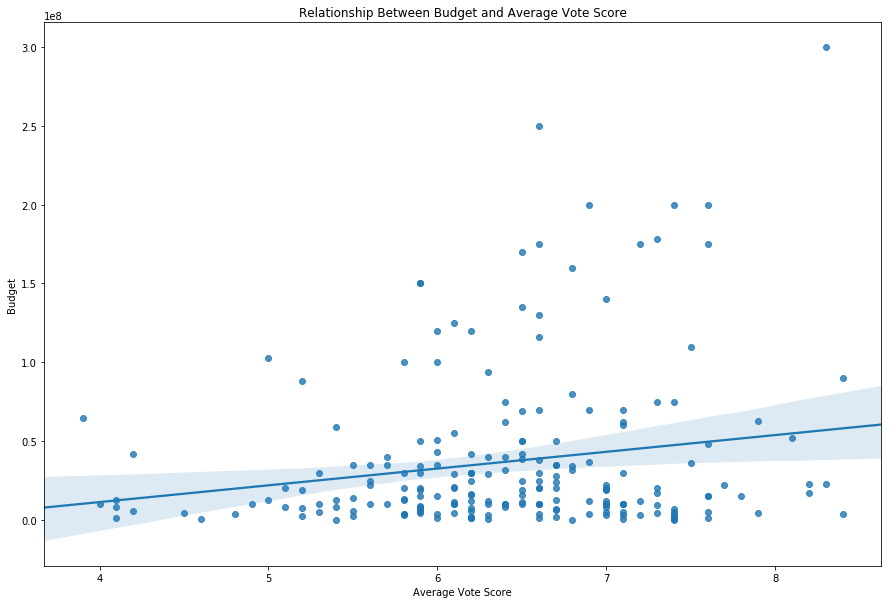

In [539]:
plt.figure(figsize=(15, 10))
sns.regplot(x = df_merged.vote_average, y = df_merged.budget_c, data = df_merged)
plt.title('Relationship Between Budget and Average Vote Score')
plt.xlabel('Average Vote Score')
pblt.ylabel('Budget')

### Pearson's R

Now we will run Pearson's R to see if there is a correlation between budget and voter score.

In [540]:
stats.pearsonr(df_merged.vote_average, df_merged.budget_c)

(0.18495217838859782, 0.006926450741945338)

## Now let's take a look at our second hypothesis:

H0 = There is no significant difference between average user rating and genre.

Our groups are not the same size so here is a quick visualization to see the breakdown. We have a total sample size of 572.

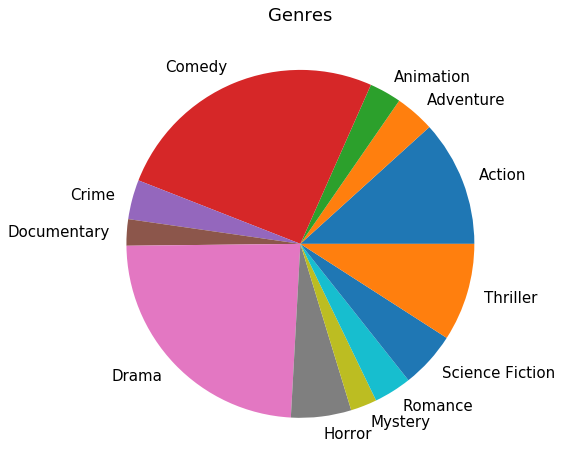

In [555]:
pie = genre_merged.groupby('genre').size()
params.update({'font.size': 15})
pie.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Genres")
plt.ylabel("")
plt.show()

I am now running a Shapiro-Wilkes Test to assess normality. We unfortunately violated this assumption.

In [558]:
stats.shapiro(genre_merged['vote_average'])

(0.9915781617164612, 0.0024627158418297768)

## One-Way ANOVA

Here I am running the one-way ANOVA. We can see that our p value is significant which tells us that genre does have an impact on user vote scores.

In [560]:
formula = 'vote_average ~ C(genre)'
lm = ols(formula, genre_merged).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

              sum_sq     df         F        PR(>F)
C(genre)   78.684307   11.0  9.498925  8.539053e-16
Residual  421.705256  560.0       NaN           NaN


Below I have run a Tukey HSD to assess the affect of each genre. I have displayed only those that reject the null hypothesis.

In [563]:
comp = pairwise_tukeyhsd(endog=genre_merged['vote_average'], groups=genre_merged['genre'], alpha=0.05)
tukey = pd.DataFrame(data=comp._results_table.data[1:], columns=comp._results_table.data[0])
tukey[tukey['reject'] == 1]

,group1,group2,meandiff,lower,upper,reject
1,Action,Animation,0.8738,0.1004,1.6473,True
4,Action,Documentary,1.4138,0.5768,2.2507,True
5,Action,Drama,0.6494,0.2248,1.0740,True
14,Adventure,Documentary,1.1405,0.1578,2.1232,True
25,Animation,Horror,-1.2779,-2.1327,-0.4232,True
26,Animation,Mystery,-1.1458,-2.1737,-0.1179,True
28,Animation,Science Fiction,-1.1296,-1.9942,-0.2650,True
29,Animation,Thriller,-0.8010,-1.5967,-0.0053,True
31,Comedy,Documentary,1.1942,0.3976,1.9908,True
32,Comedy,Drama,0.4298,0.0916,0.7680,True


### Visualization

Now we can take a look at our ANOVA in action

Text(0, 0.5, 'Average Vote Score')

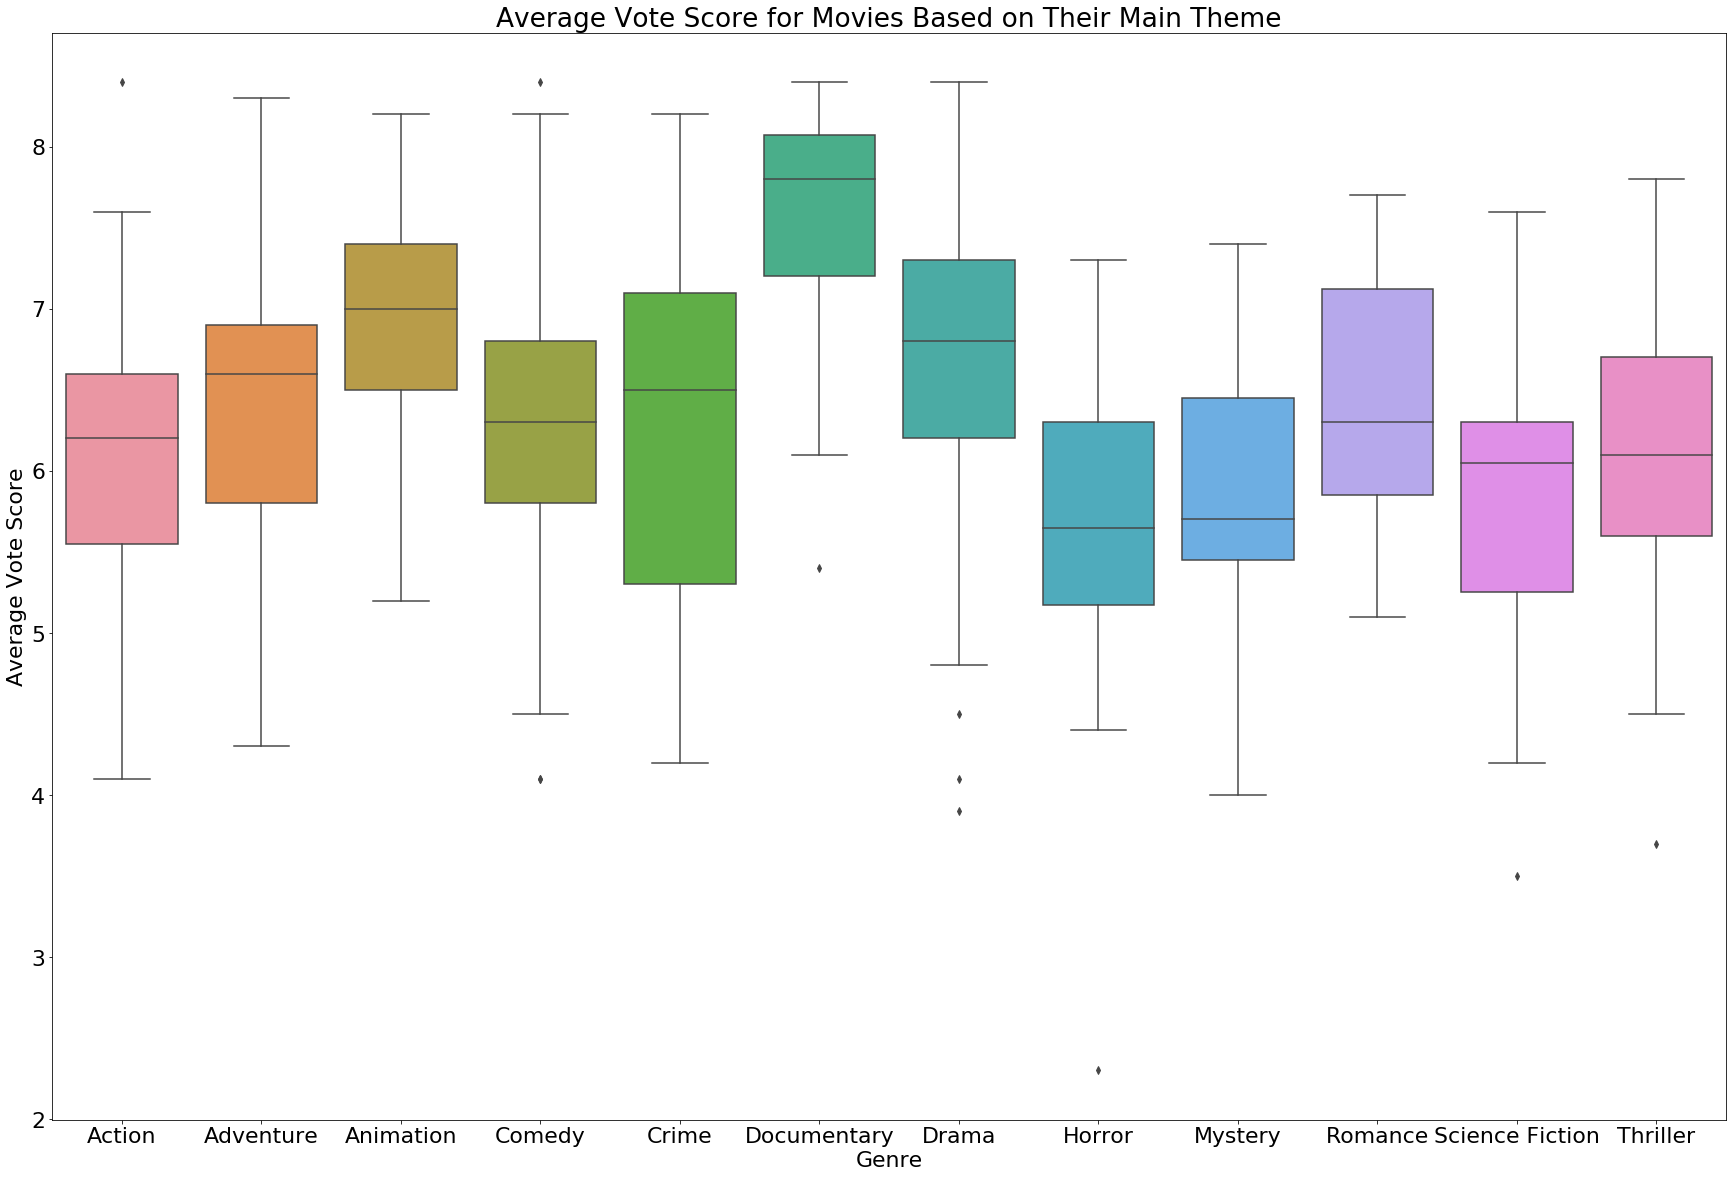

In [564]:
plt.figure(figsize=(30, 20))
params.update({'font.size': 22})
sns.boxplot(x = genre_merged['genre'], y = genre_merged['vote_average'])
plt.title('Average Vote Score for Movies Based on Their Main Theme')
plt.xlabel('Genre')
plt.ylabel('Average Vote Score')

## Our third hypothesis: 

H0: There is no significant difference in user rating between an original movie and its most recent remake.

H1: There is a significant difference in user rating between an original movie and its most recent remake.

Let's first see how our two groups (original movie and recent remake) are distributed.

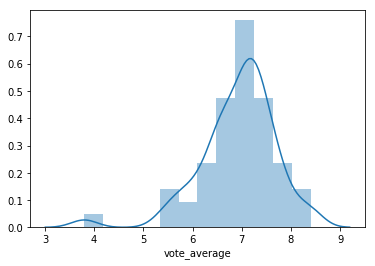

In [481]:
sns.distplot(original.vote_average)

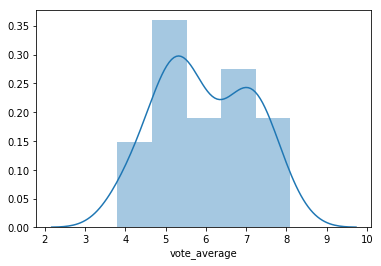

In [482]:
sns.distplot(new_remake.vote_average)

Not perfect, but we don't have a strong skew.

### Paired-Samples T-Test

As we can see, we have a significant p-value. I have set our alpha to a = 0.01.


In [483]:
stats.ttest_rel(original.vote_average, new_remake.vote_average)

Ttest_relResult(statistic=7.367641121822601, pvalue=1.0420047130882102e-09)

### Visualization

Text(0, 0.5, 'Average Vote Score')

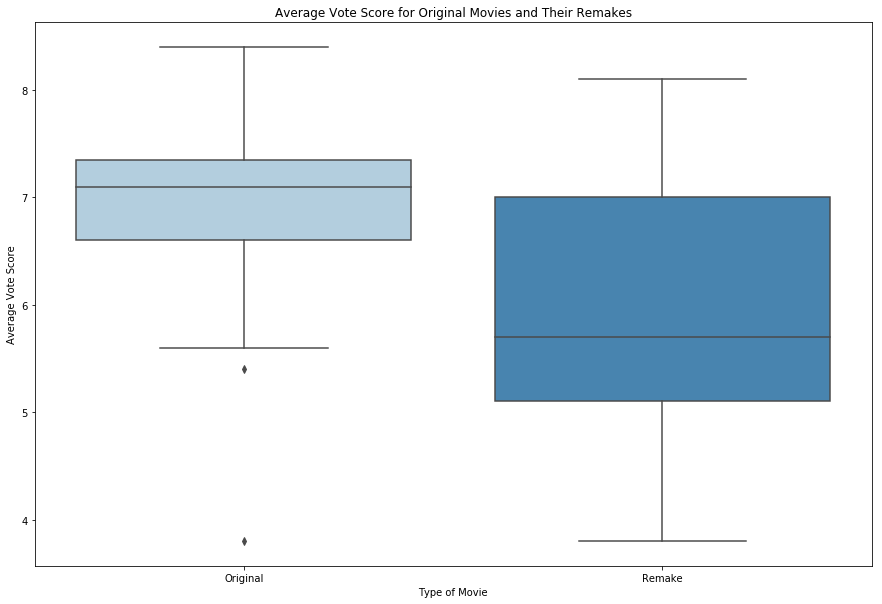

In [521]:
plt.figure(figsize=(15, 10))
sns.boxplot(x = to_plot['type'], y = to_plot['vote_average'], palette="Blues")
plt.title('Average Vote Score for Original Movies and Their Remakes')
plt.xlabel('Type of Movie')
plt.ylabel('Average Vote Score')

# Summary

As we can see from the results above, we can reject all of our null hypotheses. 

However there are some things to keep in mind:

Violation of the normality assumptions may be an issue but will hopefully be compensated by our large sample sizes. 

Further, in regard to genre, because we have grouped these as themes they are not completely independent of each other. 